In [85]:
from pulp import LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


def get_Tz(users):
    """Tz is a list of lists (a list per user) with the timezones in which each user is home and has the possibility to charge.
    A Timezone can be, for instance, (9th of march 10:30, 9th of march 12:45). They are tuples of integer indices."""
    Tz = []
    for user in users:
        availability = user.get('loadprof')
        status = 0
        start = 0
        stop = 0
        Tz_user = []
        for t in range(len(availability)):
            if availability[t] == 1 and status==0:
                start = t
                status = 1
            elif availability[t] == 0 and status==1: #in deze t laadt hij niet meer, maar in de vorige wel nog -> stop = t
                stop = t
                status = 0
                Tz_user.append((start,stop))

        Tz.append(Tz_user)

    return Tz

def get_Z(users):
    """Returns a list of number of times the car is at the chargingstation within simulation period (T) per user."""
    Z = []
    for user in users:
        Z.append(len(user.get("demandprof")))

    return Z


def get_demand(users):
    """Returns a list of demandprofiles per user. The demand profile of a user contains the amount the user wants to charge per timezone Z"""
    demand = []
    demand = []
    for user in users:
        demand.append([round(user.get("demandprof")[z][1]-user.get("demandprof")[z][0],2) for z in range(len(user.get("demandprof")))])
    
    return demand


In [86]:
import pandas as pd
import numpy as np
from random import choice


def get_production_consumption(enddatetime = '2017-12-31 23:45:00'):
    startdatetime='2017-01-01 00:00:00'
    df = pd.read_csv('Productie en verbruik info Core.csv', delimiter=';')
    df.Datum = pd.to_datetime(df.Datum + ' ' + df.Tijd)
    df.rename(columns={'Datum':'timestamp'}, inplace=True)
    df.drop(['Tijd'], axis = 1, inplace = True)
    df.set_index('timestamp', inplace=True)

    return df.loc[startdatetime:enddatetime]


def get_availability_profiles(df):

    df_av = pd.read_excel('Laadprofielen.xlsx', sheet_name='State of Charge', header=None)
    # Select rows 4 and onwards and columns D through AA
    df_av = df_av.iloc[3:, 3:26]
    # Reset column names
    df_av.columns = df_av.iloc[0]
    df_av = df_av[1:]

    for column in df_av.columns:
        col_year = list(df_av[column])*52 + list(df_av[column])[:96]
        df[column] = col_year[:len(df)]

    return df

def get_prices(df, dynamic_prices):
    df_prices = pd.read_csv('BelpexFilter.csv', delimiter=';')
    df_prices.rename(columns={'Date':'timestamp'}, inplace=True)
    df_prices.timestamp = pd.to_datetime(df_prices.timestamp)
    df_prices.sort_values('timestamp', inplace=True)
    df_prices.set_index('timestamp', inplace=True)
    df_prices.energy_price = df_prices.energy_price*1e-3 + 0.204*1e-3 #€/kWh
    df = pd.concat([df, df_prices.loc[df.index[0]:df.index[-1]]], axis=1)
    if dynamic_prices == False:
        df.energy_price = np.mean(df_prices.energy_price)

    return df


def get_demandprof(user, df):
    """..."""
    demand = []
    Tz = get_Tz([user])[0]
    for tz in Tz:
        demand.append((df[user.get('rand_profile')+' SOC [kWh]'].iloc[tz[0]], df[user.get('rand_profile')+' SOC [kWh]'].iloc[tz[1]-1]))
    return demand


def simulation(users, capaciteitspiek, dynamic_prices, PV_schaal = 1):

    df = get_production_consumption(enddatetime='2017-01-02 23:45:00')
    df['Productie in kW'] = df['Productie in kW']*PV_schaal

    print(len(df))
    df = get_availability_profiles(df)
    df = get_prices(df,dynamic_prices)

    for user in users:
        user['rand_profile'] = str(user.get("usertype"))+choice(['A','B','C'])
        user['loadprof'] = df[user.get('rand_profile')]
        user['demandprof'] = get_demandprof(user, df)


    return df, users

In [87]:
###########################################################################
### Dit is de file waarin je de parameters voor de simulatie kan kiezen ###
###########################################################################

#HTML inputs: aantal laadpalen, aantal per type, aantal autotype per type user + cap piek
nb_users_type1_bat50 = 10
nb_users_type1_bat70 = 5
nb_users_type2_bat50 = 7
nb_users_type2_bat70 = 0

cap = 25
# output van HTML:

usernames = [{'type':1, 'bat':50, 'nb':nb_users_type1_bat50},
             {'type':1, 'bat':70, 'nb':nb_users_type1_bat70},
             {'type':2, 'bat':50, 'nb':nb_users_type2_bat50},
             {'type':2, 'bat':70, 'nb':nb_users_type2_bat70},
             ]
users = []
for username in usernames:
    for nb in range(username.get('nb')):
        users.append({"username":'type'+str(username.get('type'))+'_bat'+str(username.get('bat'))+'nr'+str(username.get('nb')),"usertype":username.get('type'), "user":[11,username.get('bat')]})


# users = [
# {"user":[5,50],"loadprof":load1,"demandprof": [(0.4,1),(0.6,0.9)],"count":0,"soc":soc1},  #user = [maxrate,maxcapacity]
# {"user":[4,70],"loadprof":load2,"demandprof": [(0.5,1),(0.1,0.9),(0.6,1),(0.4,1),(0.5,1)],"count":0,"soc":soc2}  #demandprof = (aantal laadbeurten, SOC beurt, SOC beurt,....)
# ]


#################
### Simulatie ###
#################
df, users = simulation(users, cap, True, 1)


192


In [88]:

"""Optimization model. Returns optimal charging profiles s.t. the availabilities & the other constraints, aiming to maximize comfort."""  
model = LpProblem(name='laadpaalstudie', sense=LpMinimize)
T = len(df)
Z = get_Z(users)
C = len(users) #total number of users = total number of charging stations
Tz = get_Tz(users)
demand = get_demand(users)
max_charge_rate = users[0].get('user')[0]

zcharge = LpVariable.dicts('zcharge', [(c,z) for c in range(C) for z in range(Z[c])], lowBound=0)
tcharge = LpVariable.dicts('tcharge', [(c,t) for c in range(C) for t in range(T)], lowBound=0, upBound=max_charge_rate)

obj = lpSum([(demand[c][z] - zcharge[(c,z)]) for c in range(C) for z in range(Z[c])])
obj += lpSum([tcharge[(c,t)]*df['energy_price'].iloc[t] for c in range(C) for t in range(T)])
model += obj


for t in range(T):
    model += (lpSum(tcharge[(c,t)] for c in range(C)) + df['Gemeenschappelijk verbruik in kW'].iloc[t] - df['Productie in kW'].iloc[t] <= cap)
    
for c in range(C):
    for z in range(Z[c]):
        model += (zcharge[(c,z)] == lpSum([tcharge[(c,t)] for t in range(Tz[c][z][0],Tz[c][z][1])]))

        model += (zcharge[(c,z)] <= demand[c][z])



# Solve the problem
status = model.solve(use_mps=False)
assert model.status == 1

# print(f"status: {model.status}, {LpStatus[model.status]}")


print(f"objective: {model.objective.value()}")


# for var in model.variables():
#     print(f"{var.name}: {var.value()}")

# for c in range(C):
#     Z_user = []
#     for z in range (Z[c]):
#         Z_user.append(zcharge[(c,z)].value())
#     users[c]['charged_Z'] = Z_user

for c in range(C):
    users[c]['smart_profile'] = [0]*T
    for t in range(T):
        users[c]['smart_profile'][t] = tcharge[(c,t)].value()



PulpSolverError: Pulp: Error while executing c:\Users\pitou\anaconda\envs\scoptvision\lib\site-packages\pulp\solverdir\cbc\win\64\cbc.exe

In [ ]:
len(users[0]['smart_profile'])

192

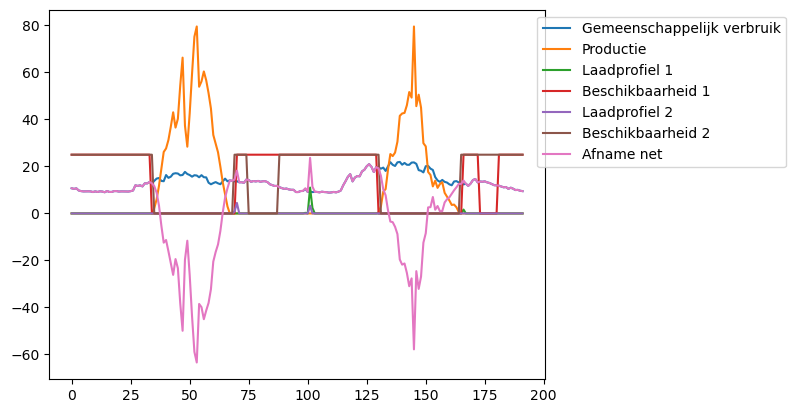

In [ ]:
plt.figure()
plt.plot(np.array(df['Gemeenschappelijk verbruik in kW']))
plt.plot(np.array(df['Productie in kW']))
# for user in users:
#     plt.plot(np.array(users[0]['smart_profile']))
plt.plot(np.array(users[0]['smart_profile']))
plt.plot(np.array(users[0]['loadprof'][:len(df)]*cap))
plt.plot(np.array(users[1]['smart_profile']))
plt.plot(np.array(users[1]['loadprof'][:len(df)]*cap))
plt.plot(np.array(users[0]['smart_profile']) + np.array(users[1]['smart_profile']) + np.array(df['Gemeenschappelijk verbruik in kW']) - np.array(df['Productie in kW']))
plt.legend(['Gemeenschappelijk verbruik', 'Productie', 'Laadprofiel 1','Beschikbaarheid 1', 'Laadprofiel 2','Beschikbaarheid 2', 'Afname net'], loc='upper right', bbox_to_anchor=(1.5, 1))
#, 'Beschikbaarheid 1','Beschikbaarheid 2'


In [ ]:
for c in range(C):
    for z in range(Z[c]):
        print(zcharge[c,z].value(), demand[c][z])

0.0 0.0
13.59 13.59
1.6350001 13.59
0.0 0.0
5.28 5.28
3.32 3.32
0.0 0.0
13.59 13.59
11.0 13.59
0.0 0.0
15.86 15.86
11.36 15.86
0.0 0.0
15.86 15.86
9.059999 15.86
0.0 0.0
15.86 15.86
11.0 15.86
0.0 0.0
15.86 15.86
11.0 15.86
0.0 0.0
5.28 5.28
3.32 3.32
0.0 0.0
13.59 13.59
12.355 13.59
0.0 0.0
15.86 15.86
3.55 15.86
0.0 0.0
5.28 5.28
3.32 3.32
0.0 0.0
15.86 15.86
15.86 15.86
0.0 0.0
13.59 13.59
11.0 13.59
0.0 0.0
15.86 15.86
15.86 15.86
0.0 0.0
15.86 15.86
15.86 15.86
0.0 0.0
3.34 3.34
0.0 0.0
3.34 3.34
0.0 0.0
3.34 3.34
3.34 3.34
0.0 0.0
0.0 0.0
3.34 3.34
0.0 0.0
3.34 3.34
0.0 0.0
